In [1]:
!pip install tensorflow.gpu    #install tensorflow gpu

     |████████████████████████████████| 497.5 MB 23 kB/s 
     |████████████████████████████████| 462 kB 8.4 MB/s 


In [2]:
!nvidia-smi   #see running gpu 

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



Import Dataset From API

In [3]:
!pip install kaggle   

In [4]:
from google.colab import files
files.upload()   #upload kaggle json API file  

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jshivam272","key":"45c31c913e9b699f0e4b9d330ffe79b4"}'}

In [5]:
!mkdir ~/.kaggle   #create folder kaggle

In [6]:
!cp kaggle.json ~/.kaggle  #copy file of API token in kaggle folder

In [7]:
! chmod 600 ~/.kaggle/kaggle.json  #change mode of API token file

In [8]:
!kaggle competitions download -c aptos2019-blindness-detection   #API of dataset

100% 9.51G/9.51G [01:06<00:00, 197MB/s]
100% 9.51G/9.51G [01:06<00:00, 153MB/s]


In [9]:
from zipfile import ZipFile  #unzip the folder
with ZipFile('/content/aptos2019-blindness-detection.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()

In [10]:
import os
import cv2
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from keras.models import Model
import PIL
import colorsys
import tensorflow
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import glob as glob
from tensorflow.keras.layers import Input,Lambda,Dense,Flatten,MaxPooling2D,Dropout
from tensorflow.keras.models import Model
#Inception V3
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Conv2D,MaxPooling2D,AveragePooling2D,BatchNormalization,Concatenate
from sklearn.model_selection import train_test_split

# Import dataset from Drive
uncomment to folow this step

In [11]:
# from google.colab import drive
# drive.mount('/content/drive')  

In [12]:
train_csv=pd.read_csv('/content/train.csv')   #train file
test_csv=pd.read_csv('/content/test.csv')     #test file

In [13]:
N_CLASSES = train_csv['diagnosis'].nunique()
train_csv["id_code"] = train_csv["id_code"].apply(lambda x: x + ".png")  #add id to png becucse its image path 
test_csv["id_code"] = test_csv["id_code"].apply(lambda x: x + ".png")    

In [14]:
train_csv

,id_code,diagnosis
0,000c1434d8d7.png,2
1,001639a390f0.png,4
2,0024cdab0c1e.png,1
3,002c21358ce6.png,0
4,005b95c28852.png,0
...,...,...
3657,ffa47f6a7bf4.png,2
3658,ffc04fed30e6.png,0
3659,ffcf7b45f213.png,2
3660,ffd97f8cd5aa.png,0


In [15]:
test_csv

,id_code
0,0005cfc8afb6.png
1,003f0afdcd15.png
2,006efc72b638.png
3,00836aaacf06.png
4,009245722fa4.png
...,...
1923,ff2fd94448de.png
1924,ff4c945d9b17.png
1925,ff64897ac0d8.png
1926,ffa73465b705.png


In [16]:
#make diagnosis columns to str because this columns has classes
train_csv['diagnosis'] = train_csv['diagnosis'].astype('str')

In [17]:
t=cv2.imread('/content/train_images/000c1434d8d7.png')

In [18]:
#function for RGB image to hsv and then apply CLAHE
from skimage import io
def img_hsv(x):
  img=io.imread('/content/train_images/'+x)     
  hsv_img=cv2.cvtColor(img, cv2.COLOR_RGB2HSV)  #convert rgb to hsv
  h,s,v=cv2.split(hsv_img)
  clahe=cv2.createCLAHE(clipLimit=0.005,tileGridSize=(8,8))  #create CLAHE
  clahe_img=clahe.apply(v) #apply to v clahe
  updated=cv2.merge((h,s,clahe_img)) #merge h,s,clahe_img
  rgb_updated=cv2.cvtColor(updated, cv2.COLOR_HSV2RGB) #again change into hsv to rgb
  plt.imsave('new'+x,rgb_updated)   #saved image



In [19]:

# train_csv['id_code']=train_csv['id_code'].apply(img_hsv)   #make a new column of new hsv images 

In [20]:
img=io.imread('/content/train_images/000c1434d8d7.png')     
hsv_img=cv2.cvtColor(img, cv2.COLOR_RGB2HSV)  #convert rgb to hsv
h,s,v=cv2.split(hsv_img)
clahe=cv2.createCLAHE(clipLimit=0.005,tileGridSize=(8,8))  #create CLAHE
clahe_img=clahe.apply(v) #apply to v clahe
updated=cv2.merge((h,s,clahe_img)) #merge h,s,clahe_img
rgb_updated=cv2.cvtColor(updated, cv2.COLOR_HSV2RGB)

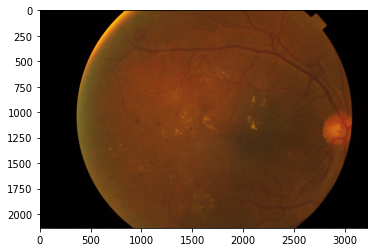

In [21]:
plt.imshow(img)  #original image

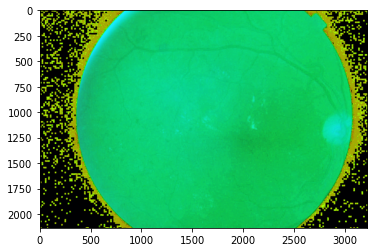

In [22]:
plt.imshow(updated)  #hsv image

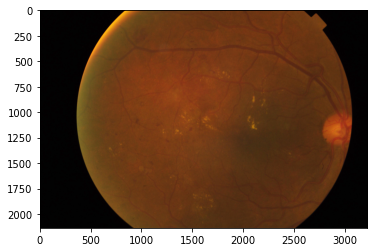

In [23]:
plt.imshow(rgb_updated)   #new rgb image

In [24]:
train_raw_data = pd.read_csv("/content/train.csv")
train_raw_data["filename"] = train_raw_data["id_code"].map(lambda x:os.path.join("/content/train_images",x+".png"))


In [25]:
train_raw_data['diagnosis']=train_raw_data['diagnosis'].astype('str')

In [26]:
test_raw_data = pd.read_csv("/content/test.csv")
test_raw_data['filename']=test_raw_data['id_code'].map(lambda x: os.path.join('/content/test_images',x+'.png'))

In [27]:
train_raw_data.head()


,id_code,diagnosis,filename
0,000c1434d8d7,2,/content/train_images/000c1434d8d7.png
1,001639a390f0,4,/content/train_images/001639a390f0.png
2,0024cdab0c1e,1,/content/train_images/0024cdab0c1e.png
3,002c21358ce6,0,/content/train_images/002c21358ce6.png
4,005b95c28852,0,/content/train_images/005b95c28852.png


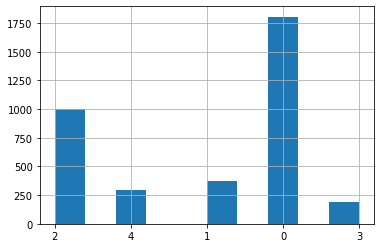

In [28]:
train_raw_data.diagnosis.hist()   #how many classes are there for corresponding images

In [29]:
test_raw_data.head()

,id_code,filename
0,0005cfc8afb6,/content/test_images/0005cfc8afb6.png
1,003f0afdcd15,/content/test_images/003f0afdcd15.png
2,006efc72b638,/content/test_images/006efc72b638.png
3,00836aaacf06,/content/test_images/00836aaacf06.png
4,009245722fa4,/content/test_images/009245722fa4.png


In [30]:
label_title = {"0" : "No DR","1" : "Mild","2" : "Moderate","3" :"Severe","4" : "Proliferative DR"}
class_labels=["No DR","Mild","Moderate","Severe","Proliferative DR"]   #class labels

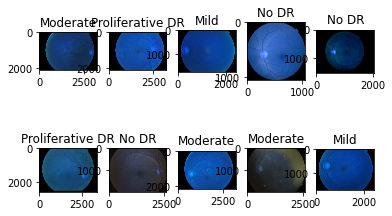

In [31]:
# Display some images
figure, ax = plt.subplots(2,5)
ax = ax.flatten()
for i,row in train_raw_data.iloc[0:10,:].iterrows():
    ax[i].imshow(cv2.imread(os.path.join("/content/train_images/",row["id_code"]+".png")))
    ax[i].set_title(label_title[str(row["diagnosis"])])

Data Augmentation by doing some transformations in train dataset

In [32]:

train_path='/content/train_images/'
test_path='/content/test_images/'

In [33]:
train_data_new=train_raw_data
# validation_data_new=train_raw_data.iloc[2501:]

In [34]:
#use the Image Data Generator to do augmentations in data
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#data augmentation for train data
train_datagen=ImageDataGenerator(rescale=1./255,
                                 shear_range=0.2,
                                 zoom_range=0.2,
                                 horizontal_flip=True)

#data augmentation for test data
test_datagen=ImageDataGenerator(rescale=1./255)

In [35]:
#for train data
training_set=train_datagen.flow_from_dataframe(
    train_data_new,
    directory=None,
    x_col='filename',
    y_col='diagnosis',
    weight_col=None,
    target_size=(299, 299),
    color_mode='rgb',
    classes=None,
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=None,
    save_to_dir=None,
    save_prefix='',
    save_format='png',
    subset=None,
    interpolation='nearest',
    validate_filenames=True
)

Found 3662 validated image filenames belonging to 5 classes.


In [36]:
test_generator = test_datagen.flow_from_dataframe(  
        dataframe=test_raw_data,
        directory='/content/test_images',
        x_col="filename",
        target_size=(299,299),
        batch_size=32,
        shuffle=False,
        class_mode=None)

Found 1928 validated image filenames.


In [37]:
data=[]      #resized all images (299,299,3)

for i in train_raw_data['filename']:   
    image=tensorflow.keras.preprocessing.image.load_img(i, color_mode='rgb',target_size= (299,299))
    image=np.array(image)
    data.append(image)

In [38]:
#converted images into numpy array
data=np.array(data)
labels=np.array(train_raw_data['diagnosis'])

In [39]:
#train test split
from sklearn.model_selection import train_test_split
data_train_inc,data_test_inc,y_train_inc,y_test_inc=train_test_split(data,labels,random_state=272,test_size=0.3)

In [40]:
print('Len of train set is: ',len(data_train_inc))
print('Len of test set is: ',len(data_test_inc))

Len of train set is:  2563
Len of test set is:  1099


Inception V3

In [45]:
inception=InceptionV3(input_shape=(299,299,3),weights='imagenet',include_top=False)

87924736/87910968 [==============================] - 1s 0us/step


In [46]:
#dont train existing weights
for layers in inception.layers:
  layers.trainable=False

In [47]:
transfer_model=inception.output
transfer_model=MaxPooling2D(pool_size=(4, 4))(transfer_model)
transfer_model=Flatten()(transfer_model)
transfer_model=Dense(64, activation='relu')(transfer_model)
transfer_model=Dropout(0.2)(transfer_model)
transfer_model=Dense(5, activation='softmax')(transfer_model)

In [48]:
#create a model object
model=Model(inputs=inception.input,outputs=transfer_model)

diagnosis_dict = {
    0:'No DR',
    1:'Mild',
    2:'Moderate',
    3: 'Severe',
    4: 'Proliferative DR'
}

In [49]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [50]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])


In [51]:
lrd=ReduceLROnPlateau(monitor='val_loss',patience=2,verbose=1,factor=0.8,min_lr=1e-6)
es=EarlyStopping(verbose=1,patience=2)

In [52]:
# model.fit(
#                    training_set,
#                     steps_per_epoch=100,
#                     epochs=10,
#                     validation_data=valid_set,
#                     validation_steps=50,
#                     callbacks=[lrd,es]

# )

In [54]:
train_features=model.predict(data_train_inc)
test_features=model.predict(data_test_inc)

Resnet 50

In [59]:
resnet=ResNet50(weights='imagenet')

102981632/102967424 [==============================] - 1s 0us/step


In [60]:
for layer in resnet.layers:
  layer.trainable=False

In [61]:
x=resnet.output
x=Dense(5,activation='softmax')(x)
model_res=Model(inputs=resnet.input,outputs=x)


In [62]:
model_res.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [63]:
#reized data according to resnet model
data_res=[]

for i in train_raw_data['filename']:   
    image=tensorflow.keras.preprocessing.image.load_img(i, color_mode='rgb',target_size= (224,224))
    image=np.array(image)
    data_res.append(image)

In [64]:
#changed into numpy array
data_res=np.array(data_res)  
labels_res=np.array(train_raw_data['diagnosis'])

In [65]:
#train test split
from sklearn.model_selection import train_test_split
data_train_res,data_test_res,y_train_res,y_test_res=train_test_split(data_res,labels_res,random_state=272,test_size=0.3)

In [66]:
#prediction 
train_features_res=model_res.predict(data_train_res)
test_features_res=model_res.predict(data_test_res)

Google Net

In [68]:
#copy from resent because dont need to resize again same as resnet
data_gle=data_res
labels_gle=labels_res

In [69]:
#copy from resnet model
data_train_gle=data_train_res
data_test_gle=data_test_res
y_train_gle=y_train_res
y_test_gle=y_test_res

In [70]:
data_train_gle.shape

(2563, 224, 224, 3)

In [71]:
# create model
def inception(x, filters):
    # 1x1
    path1 = Conv2D(filters=filters[0], kernel_size=(1,1), strides=1, padding='same', activation='relu')(x)

    # 1x1->3x3
    path2 = Conv2D(filters=filters[1][0], kernel_size=(1,1), strides=1, padding='same', activation='relu')(x)
    path2 = Conv2D(filters=filters[1][1], kernel_size=(3,3), strides=1, padding='same', activation='relu')(path2)
    
    # 1x1->5x5
    path3 = Conv2D(filters=filters[2][0], kernel_size=(1,1), strides=1, padding='same', activation='relu')(x)
    path3 = Conv2D(filters=filters[2][1], kernel_size=(5,5), strides=1, padding='same', activation='relu')(path3)

    # 3x3->1x1
    path4 = MaxPooling2D(pool_size=(3,3), strides=1, padding='same')(x)
    path4 = Conv2D(filters=filters[3], kernel_size=(1,1), strides=1, padding='same', activation='relu')(path4)

    return Concatenate(axis=-1)([path1,path2,path3,path4])

def auxiliary(x, name=None):
    layer = AveragePooling2D(pool_size=(5,5), strides=3, padding='valid')(x)
    layer = Conv2D(filters=128, kernel_size=(1,1), strides=1, padding='same', activation='relu')(layer)
    layer = Flatten()(layer)
    layer = Dense(units=256, activation='relu')(layer)
    layer = Dropout(0.4)(layer)
    layer = Dense(units=5, activation='softmax', name=name)(layer)
    return layer


def googlenet():
    layer_in = Input(shape=(224,224,3))
    
    # stage-1
    layer = Conv2D(filters=64, kernel_size=(7,7), strides=2, padding='same', activation='relu')(layer_in)
    layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)
    layer = BatchNormalization()(layer)

    # stage-2
    layer = Conv2D(filters=64, kernel_size=(1,1), strides=1, padding='same', activation='relu')(layer)
    layer = Conv2D(filters=192, kernel_size=(3,3), strides=1, padding='same', activation='relu')(layer)
    layer = BatchNormalization()(layer)
    layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)

    # stage-3
    layer = inception(layer, [ 64,  (96,128), (16,32), 32]) #3a
    layer = inception(layer, [128, (128,192), (32,96), 64]) #3b
    layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)
    
    # stage-4
    layer = inception(layer, [192,  (96,208),  (16,48),  64]) #4a
    aux1  = auxiliary(layer, name='aux1')
    layer = inception(layer, [160, (112,224),  (24,64),  64]) #4b
    layer = inception(layer, [128, (128,256),  (24,64),  64]) #4c
    layer = inception(layer, [112, (144,288),  (32,64),  64]) #4d
    aux2  = auxiliary(layer, name='aux2')
    layer = inception(layer, [256, (160,320), (32,128), 128]) #4e
    layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)
    
    # stage-5
    layer = inception(layer, [256, (160,320), (32,128), 128]) #5a
    layer = inception(layer, [384, (192,384), (48,128), 128]) #5b
    layer = AveragePooling2D(pool_size=(7,7), strides=1, padding='valid')(layer)
    
    # stage-6
    layer = Flatten()(layer)
    layer = Dropout(0.4)(layer)
    layer = Dense(units=256, activation='linear')(layer)
    main = Dense(units=5, activation='softmax', name='main')(layer)
    
    model = Model(inputs=layer_in, outputs=[main, aux1, aux2])
    
    return model

In [72]:
# train model
gle = googlenet()
gle.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 112, 112, 64  9472        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_5 (MaxPooling2D)  (None, 56, 56, 64)  0           ['conv2d_94[0][0]']              
                                                                                            

In [73]:
gle.compile(loss='sparse_categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

In [74]:
train_features_gle=gle.predict(data_train_gle)  #prediction of train data


In [75]:
test_features_gle=gle.predict(data_test_gle)   #predictrion of test data

In [77]:
len(train_features)

2563

In [78]:
len(train_features_res)

2563

In [79]:
train_features_gle_new=train_features_gle[0]  

In [80]:
test_features_gle_new=test_features_gle[0]

In [81]:
len(train_features_gle_new)

2563

Integration of Models

In [82]:
train=np.add(train_features,train_features_res,train_features_gle_new)   #integrated threee models

In [83]:
train_features_res.shape

(2563, 5)

In [84]:
train.shape

(2563, 5)

In [85]:
test=np.add(test_features,test_features_res,test_features_gle_new)

In [86]:
test.shape

(1099, 5)

Autoencoder part

In [127]:
# AutoEncoder 
 
#encoder part
auto=Sequential()
auto.add(Dense(64,input_dim=5,activation='relu'))
auto.add(Dense(32,activation='relu'))
auto.add(Dense(16,activation='relu'))
auto.add(Dense(8,activation='relu'))
#decoder part
auto.add(Dense(16,activation='relu'))
auto.add(Dense(32,activation='relu'))
auto.add(Dense(64,activation='relu'))
auto.add(Dense(5,activation='softmax'))


In [128]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping=EarlyStopping(monitor='val_loss',patience=2,mode='min')
auto.compile(loss='mean_squared_error',optimizer='adam')
auto.fit(train,train,verbose=1,epochs=1000,batch_size=28,shuffle=False,callbacks=[early_stopping])

Epoch 1/1000
92/92 [==============================] - 1s 3ms/step - loss: 0.0919
Epoch 2/1000
92/92 [==============================] - 0s 3ms/step - loss: 0.0404
Epoch 3/1000
92/92 [==============================] - 0s 3ms/step - loss: 0.0403
Epoch 4/1000
92/92 [==============================] - 0s 3ms/step - loss: 0.0402
Epoch 5/1000
92/92 [==============================] - 0s 2ms/step - loss: 0.0402
Epoch 6/1000
92/92 [==============================] - 0s 3ms/step - loss: 0.0401
Epoch 7/1000
92/92 [==============================] - 0s 3ms/step - loss: 0.0401
Epoch 8/1000
92/92 [==============================] - 0s 3ms/step - loss: 0.0401
Epoch 9/1000
92/92 [==============================] - 0s 3ms/step - loss: 0.0401
Epoch 10/1000
92/92 [==============================] - 0s 2ms/step - loss: 0.0400
Epoch 11/1000
92/92 [==============================] - 0s 3ms/step - loss: 0.0400
Epoch 12/1000
92/92 [==============================] - 0s 3ms/step - loss: 0.0400
Epoch 13/1000
92/92 [====

In [129]:
pred_train=auto.predict(train)  #predicted train data
train_loss=tensorflow.keras.losses.mae(pred_train,train)  #find mean absolute error of predictd train data

In [130]:
pred_test=auto.predict(test)   #predicted test data
test_loss=tensorflow.keras.losses.mae(pred_test,test)  #find mean absolute error of predicted test data

In [131]:
predicted_train=[str(np.argmax(i)) for i in pred_train]   #found maximum probability class of train data

In [132]:
predicted_test=[str(np.argmax(i)) for i in pred_test]     #found maximum probability class of test data

Metrics Of Data

In [133]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score,recall_score,precision_score
print()
print('----------------------------------------------------------------For Training Data------------------------------------------------------------------------')
print()
rep_train=classification_report(predicted_train,y_train_res)
print(rep_train)
print()
print('='*150)
print()
print('----------------------------------------------------------------For Testing Data------------------------------------------------------------------------')
print()
rep_test=classification_report(predicted_test,y_test_res)
print(rep_test)


----------------------------------------------------------------For Training Data------------------------------------------------------------------------

              precision    recall  f1-score   support

           0       0.96      0.51      0.67      2353
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.17      0.12      0.14       210
           4       0.00      0.00      0.00         0

    accuracy                           0.48      2563
   macro avg       0.23      0.13      0.16      2563
weighted avg       0.89      0.48      0.63      2563



----------------------------------------------------------------For Testing Data------------------------------------------------------------------------

              precision    recall  f1-score   support

           0       0.96      0.51      0.67      1016
           1       0.00      0.00      0.00         0
           2       0.00      0.00   

In [134]:
#precison, recall,specificity,accuracy
pred_train_rc=recall_score(predicted_train,y_train_res,average='weighted')
pred_test_rc=recall_score(predicted_test,y_test_res,average='weighted')
pred_train_pr=precision_score(predicted_train,y_train_res,average='weighted')
pred_test_pr=precision_score(predicted_test,y_test_res,average='weighted')
pred_train_acc=accuracy_score(predicted_train,y_train_res)
pred_test_acc=accuracy_score(predicted_test,y_test_res)
print('Recall Score Of Trainig Data',pred_train_rc)
print('Recall Score Of Testing Data',pred_test_rc)
print('Precision Score Of Training Data',pred_train_pr)
print('Precision Score Of Testing Data',pred_test_pr)
print('Accuracy Score Of Trainig Data',pred_train_acc)
print('Accuracy Score Of Testing Data',pred_test_acc)


Recall Score Of Trainig Data 0.481857198595396
Recall Score Of Testing Data 0.47952684258416745
Precision Score Of Training Data 0.8917205885386433
Precision Score Of Testing Data 0.9022564130844386
Accuracy Score Of Trainig Data 0.481857198595396
Accuracy Score Of Testing Data 0.47952684258416745


In [135]:
#heat map function
def conf_heat(pred,true):
  cm=confusion_matrix(pred,true)
  plt.figure(figsize=(10,8))
  ti=np.arange(0,5)
  sns.heatmap(cm,annot=True,cmap=plt.cm.YlOrRd)
  plt.xlabel('Predicted Classes')
  plt.ylabel('True Classes')
  plt.title('Confusion Matrix ')
  plt.xticks(ti,labels=["No DR","Mild","Moderate","Severe","Proliferative DR"],rotation=90)
  plt.yticks(ti,labels=["No DR","Mild","Moderate","Severe","Proliferative DR"])
  plt.show()



----------------------------------------------------------------For Trainig Data-------------------------------------------------------------------



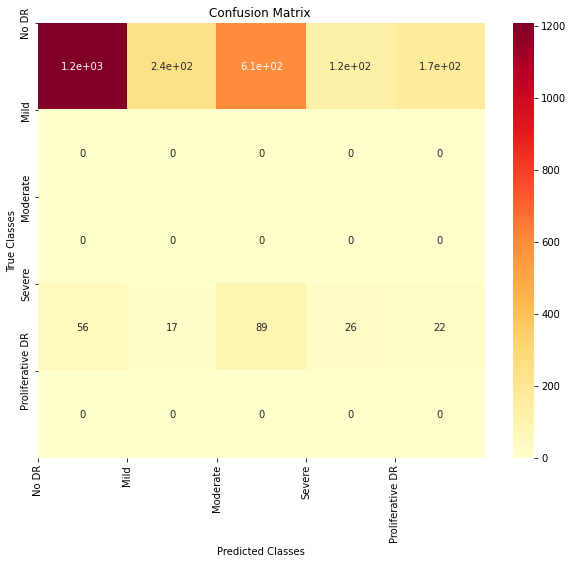



----------------------------------------------------------------For Testing Data-------------------------------------------------------------------



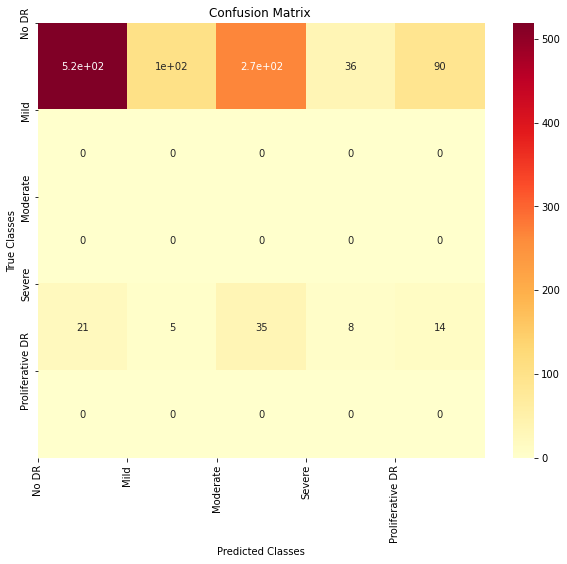

In [136]:
#confusion Matrix
print()
print('----------------------------------------------------------------For Trainig Data-------------------------------------------------------------------')
print()
conf_heat(predicted_train,y_train_res)
print()
print('='*150)
print()
print('----------------------------------------------------------------For Testing Data-------------------------------------------------------------------')
print()
conf_heat(predicted_test,y_test_res)